![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

### Variables

**datetime** = hourly date + timestamp

**season**  1 = spring, 2 = summer, 3 = fall, 4 = winter

**holiday** = whether the day is considered a holiday

**workingday** = whether the day is neither a weekend nor holiday

**weather** 1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
            
**temp** = temperature in Celsius

**atemp** = "feels like" temperature in Celsius

**humidity** = relative humidity

**windspeed** = wind speed

**casual** = number of non-registered user rentals initiated

**registered** = number of registered user rentals initiated

**count**= number of total rentals

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import plot_tree
plt.rcParams["figure.figsize"] = (25,14)
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [4]:
bikes.shape

(10886, 12)

### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [5]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [6]:
bikes.groupby('workingday').total.describe(percentiles=[0.25,0.5,0.75,0.9])

,count,mean,std,min,25%,50%,75%,90%,max
workingday,,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,451.7,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,452.9,977.0


In [7]:
bikes[bikes["total"]==bikes["total"].max()]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2012-09-12 18:00:00,3,0,1,1,27.06,31.06,44,16.9979,91,886,977,18


### Variable "workingday"
El análisis de la variable **workingday** muestra que el numero de alquileres para días entre semana y no festivos **7412**, dobla en numero comparado con los alquileres para días feriados y fines de semana **3474**. El valor máximo de alquiler en una hora es **977** para un día entre semana no festivo y se da a las 6 de la tarde en estación de otoño y en un clima optimo para montar bicicleta y  supera en **194** el máximo para un día feriado o fin de semana. Por otra parte el promedio de alquileres por hora es bastante similar en ambos casos con un leve aumento de **5 alquileres** en el caso de días entre semana y no feriados, situación similar se observa con el percentil 90 ya que el **90%** de los alquileres ronda los **452** por hora o menos.

In [8]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [9]:
bikes.groupby('hour').total.describe(percentiles=[0.25,0.5,0.75,0.9])

,count,mean,std,min,25%,50%,75%,90%,max
hour,,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,116.6,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,92.7,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,69.0,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,31.0,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,12.0,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,38.0,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,152.0,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,458.2,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,681.6,839.0


### Variable "hour"

El análisis de la variable **hour** muestra que a partir de las 4 pm se presenta un incremento significativo hasta las 7 pm con los valores mas altos a las 5 y 6 pm. Para estas horas coinciden los mejores promedios **468** a las 5 pm y **430** a las 6 pm. Los valores mas bajos se presentan en horas opuestas a las 4 am y 5 am. El valor mas alto de alquiler corresponde a las 6 pm con **977** bicicletas alquiladas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

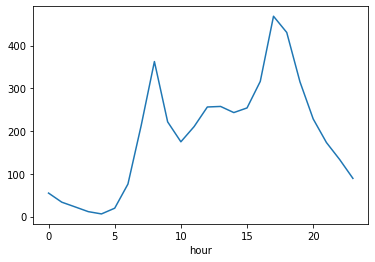

In [10]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

Text(0.5, 0, 'Hora')

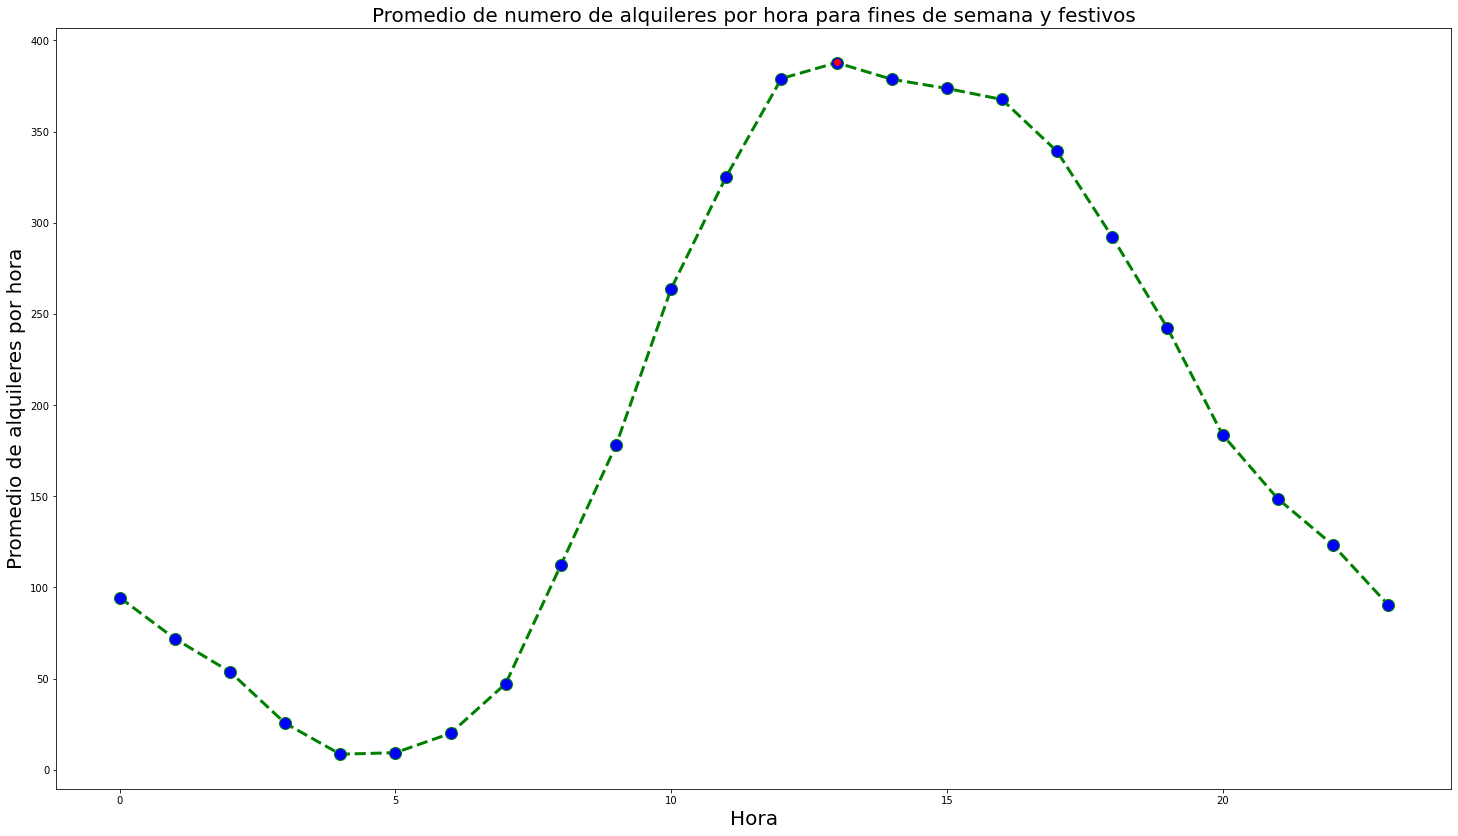

In [54]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 

bikes[bikes["workingday"]==0].groupby('hour').total.mean().plot(color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.title('Promedio de numero de alquileres por hora para fines de semana y festivos',fontsize=20)
plt.ylabel('Promedio de alquileres por hora',fontsize=20)
plt.plot(13,388, marker="o", color="red")
plt.xlabel('Hora',fontsize=20)

In [12]:
# valor máximo promedio de alquiler a la 1 pm para fines de semana y festivos
bikes[bikes["workingday"]==0].groupby('hour').total.mean()[13]

387.82068965517243

### Promedio de alquiler en fines de semana o festivos

De acuerdo con la grafica se presentan cerca de 94 rentas a las 12 de la media noche y empiezan a descender hasta las 5 am,luego los alquileres aumentan cada hora hasta la **1 pm**  llegando a un máximo promedio cercano a las **388** rentas y se mantienen moderadamente estables hasta las 4pm y luego empiezan a descender gradualmente hasta el fin del dia.

Text(0.5, 0, 'Hora')

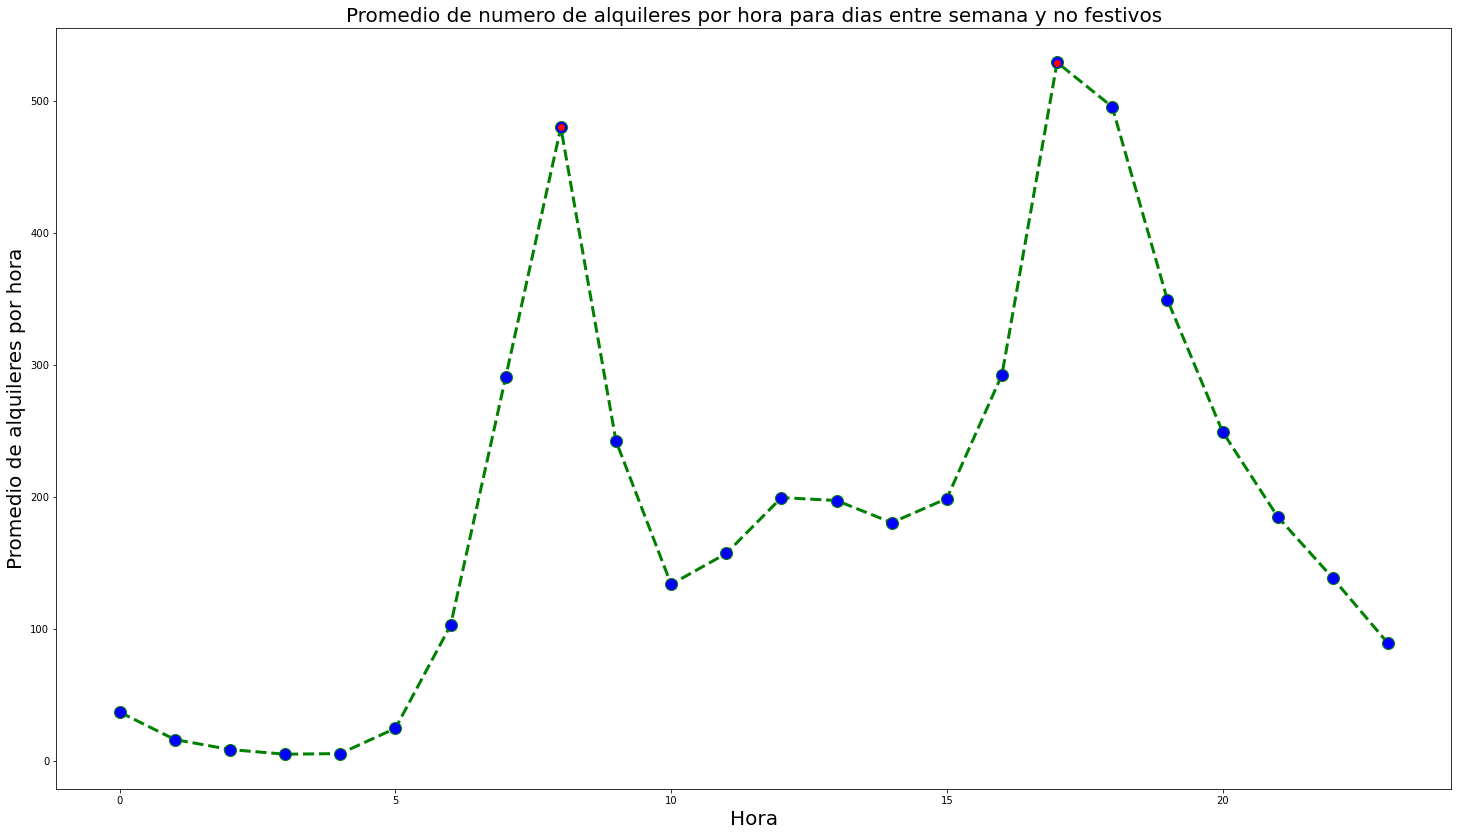

In [13]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes["workingday"]==1].groupby('hour').total.mean().plot(color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.title('Promedio de numero de alquileres por hora para dias entre semana y no festivos',fontsize=20)
plt.ylabel('Promedio de alquileres por hora',fontsize=20)
plt.plot(8,480, marker="o", color="red")
plt.plot(17,529, marker="o", color="red")
plt.xlabel('Hora',fontsize=20)


In [14]:
# valor máximo promedio de alquiler a las 5 pm para dias entre semana y no feriados
bikes[bikes["workingday"]==1].groupby('hour').total.mean()[17]

529.2090032154341

### Promedio de alquiler para dias entre semana y no feriados

Según la grafica se presentan muy pocos alquileres a las 12 de la noche y se mantienen moderadamente estables hasta las 5 pm donde empiezan a aumentar radicalmente hasta las **8 am** alcanzando un pico de **480** y luego se desciende fuertemente hasta las 10 am con un leve repunte hasta las 12 del medio día y conservando un numero de alquileres similares  y cercanos a 200 alquileres hasta las 3pm, a partir de las 3 pm se presenta un nuevo repunte hasta las **5 pm** con el pico máximo de alquileres de **529**, posteriormente hay un descenso gradual hasta el fin del día.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [15]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
X = bikes[['hour', 'workingday']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )
modelo = LinearRegression()
modelo.fit(X = X_train, y = y_train)



LinearRegression()

In [16]:
print("Intercept:", modelo.intercept_)
print("Coeficiente:", list(zip(X.columns, modelo.coef_.flatten(), )))
print("Coeficiente de determinación R^2:", modelo.score(X_train, y_train))

Intercept: 67.27816003046848
Coeficiente: [('hour', 10.329235916669473), ('workingday', 7.050292296522294)]
Coeficiente de determinación R^2: 0.15710321196818344


In [19]:
# predicciones y error MSE
predicciones = modelo.predict(X = X_test)


rmse_regresion = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse_regresion}")


El error (rmse) de test es: 163.2399717241645


### Modelo de Regresión Lineal

El modelo lineal generado sigue la ecuación:

#### total = 67.27816003046848 + 10.329235916669473 *hour + 7.050292296522294 * workingday

Por cada unidad que se incrementa el número de horas, el número del total de alquileres aumenta en promedio **10.329235916669473** unidades.

Por cada unidad que se incrementa el número de días entre semana y no festivos, el número del total de alquileres aumenta en promedio **7.050292296522294 unidades**.

El error de test del modelo es de **163.24**. Las predicciones del modelo final se alejan en promedio **163.24** unidades del valor real.

#### Limitaciones

El error cuadratico medio de test evidencia que el modelo presenta un error de **163.24** que no permite una buena predicción de los valores de alquiler de bicicletas usando las variables hour y workingday. Estas variables por si solas dan una aproximación muy leve de la cantidad de alquileres de bicicletas debido a que estas variables no siempre son homogéneas para las personas que van a alquilar, ya que cada día y hora es afectado por otras variables que influyen significativamente en la posibilidad o no de realizar el alquiler. De esta manera las condiciones climáticas pueden cambiar totalmente las posibilidades del alquiler, así como las diferentes estaciones entre otras posibles variables.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [29]:
# Celda 4
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


In [30]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [31]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [32]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [33]:
# Aplicación de la función tree_grow
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)
tree

{'y_pred': 191.19866789159394,
 'y_prob': 191.1548794489093,
 'level': 0,
 'split': [0, 6.0],
 'n_samples': 8708,
 'gain': 18152.027742768798,
 'sl': {'y_pred': 26.03771849126035,
  'y_prob': 26.014246323529413,
  'level': 1,
  'split': [0, 2.0],
  'n_samples': 2174,
  'gain': 398.75694544784756,
  'sl': {'y_pred': 45.65363881401617,
   'y_prob': 45.53225806451613,
   'level': 2,
   'split': [1, 1.0],
   'n_samples': 742,
   'gain': 1431.3226560838666,
   'sl': {'y_pred': 82.62352941176471,
    'y_prob': 81.98443579766537,
    'level': 3,
    'split': [0, 1.0],
    'n_samples': 255,
    'gain': 271.9176356312364,
    'sl': {'y_pred': 94.14728682170542,
     'y_prob': 92.7175572519084,
     'level': 4,
     'split': -1,
     'n_samples': 129,
     'gain': 0},
    'sr': {'y_pred': 70.82539682539682,
     'y_prob': 69.7265625,
     'level': 4,
     'split': -1,
     'n_samples': 126,
     'gain': 0}},
   'sr': {'y_pred': 26.295687885010267,
    'y_prob': 26.190184049079754,
    'level': 3

In [34]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [35]:
# Ejecución de función tree_predict
tree_predict(X_test, tree)

array([186.06162791,  70.82539683, 186.06162791, ..., 186.06162791,
       309.24489796,  77.41452991])

In [36]:
rmse_manual = mean_squared_error(
        y_true  = y_test,
        y_pred  = tree_predict(X_test, tree),
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse_manual}")


El error (rmse) de test es: 121.20766991631115


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [37]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

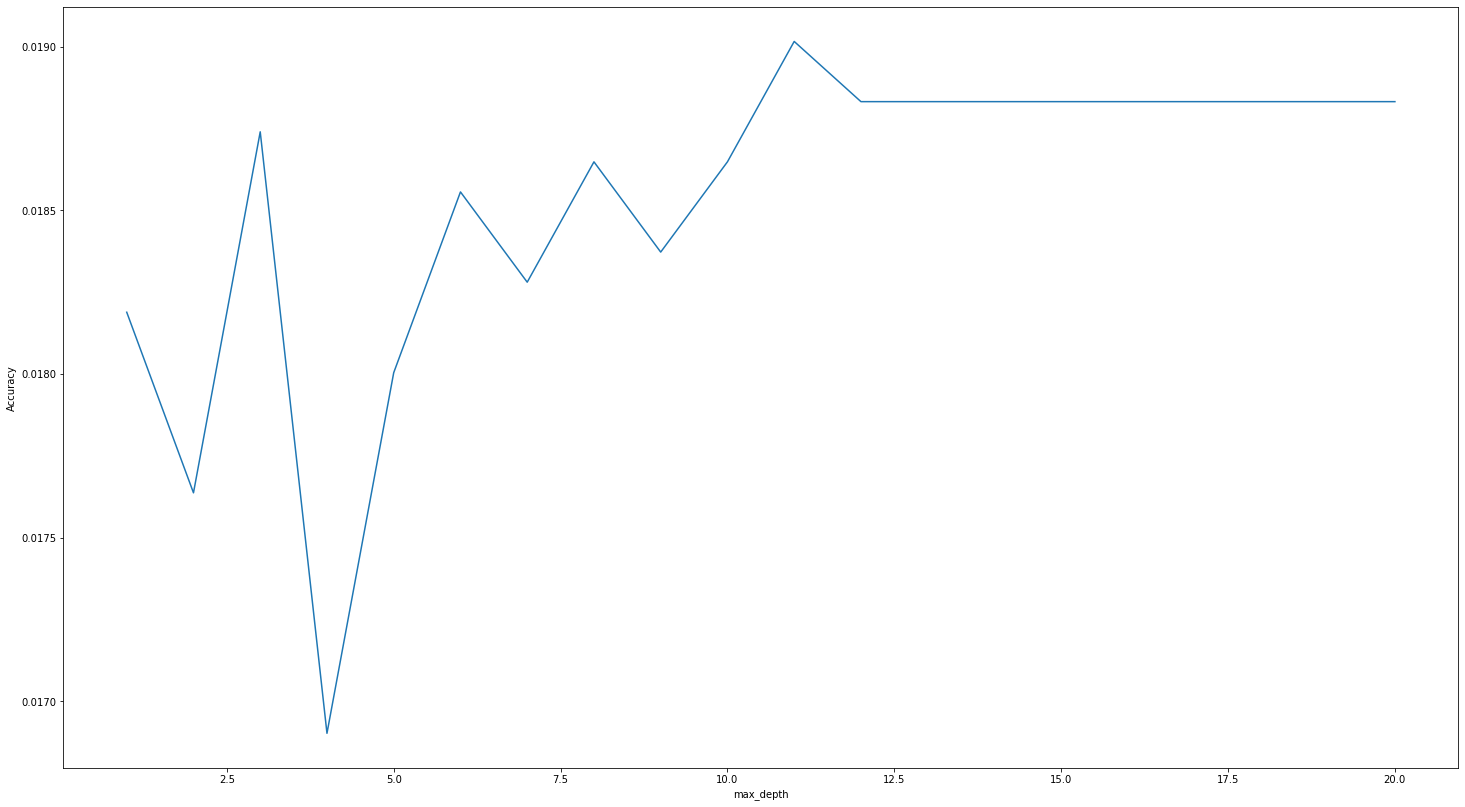

In [55]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [39]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.01901543847566575, 11)

In [40]:
# max_depth=11 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=11, random_state=1)
Tree_ajustado=clf.fit(X_train, y_train)

In [41]:
# predicciónes 
predTree = Tree_ajustado.predict(X_test)

In [42]:
print (predTree [0:5])
print (y_test.values[0:5])

[202  24 178   2  55]
[185  75 163  13 326]


In [43]:
rmse_libreria = mean_squared_error(
        y_true  = y_test,
        y_pred  = predTree,
        squared = False
       )
print("")
print(f"El error (rmse) de test es: {rmse_libreria}")


El error (rmse) de test es: 144.94700592661124


In [44]:
print("Accuracy Árbol de decisión max depth 11:", metrics.accuracy_score(predTree , y_test))

Accuracy Árbol de decisión max depth 11: 0.020202020202020204


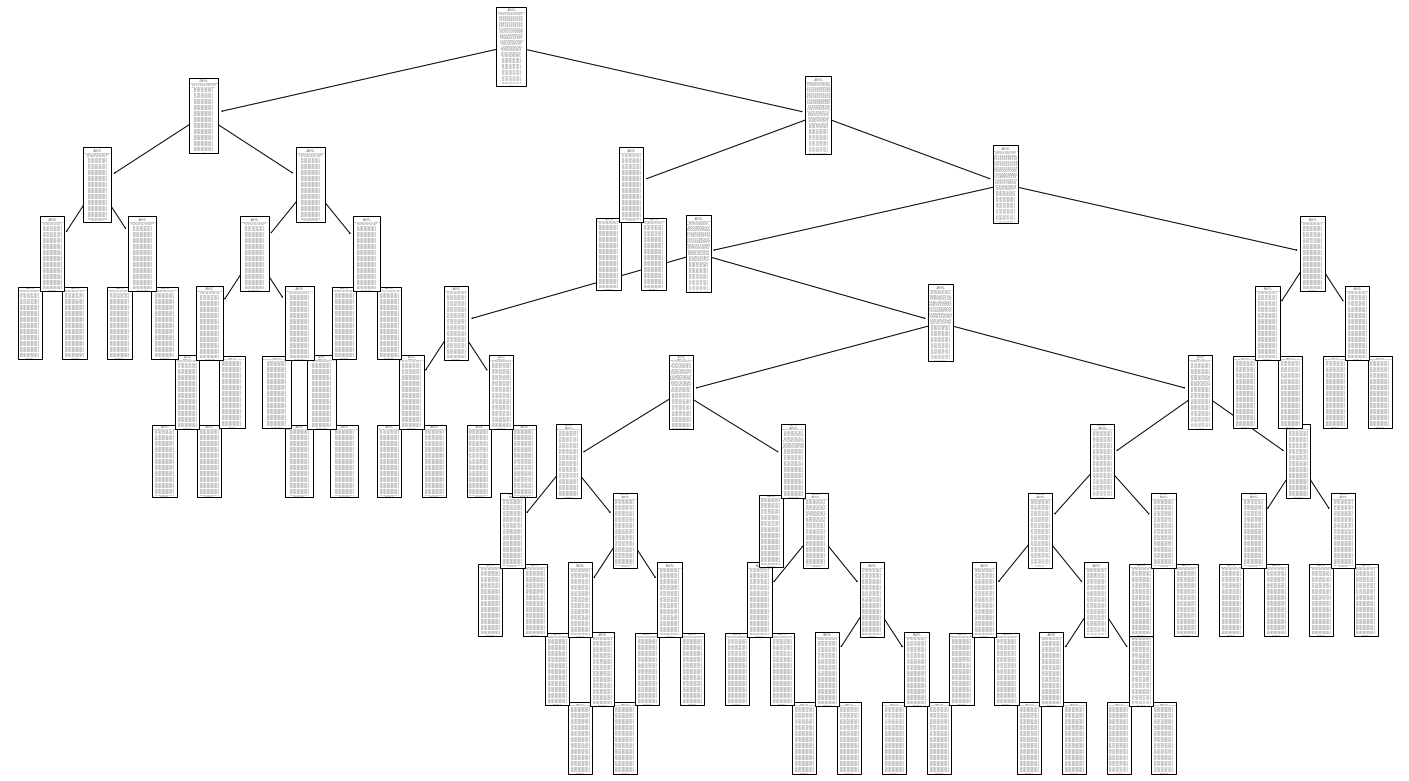

In [56]:
plot_tree(Tree_ajustado,max_depth=11)
plt.show()

In [51]:
# Uso de la función .feature_importances_ para obtener la importancia de cada variable
pd.DataFrame({'feature':X.columns, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
1,workingday,0.245475
0,hour,0.754525


El árbol usando la librería sklearn con una profundidad de máxima de 11 tiene un error cuadrático medio MSE de **144.95**, es decir las predicciones del modelo final se alejan en promedio **144.95** unidades del valor real. Para este árbol es mucho mas importante la variable hour que la variable workingday. El valor del accuracy es muy bajo **0.020** y deja en evidencia que el modelo no es adecuado para predecir el alquiler de bicicletas.

### Comparativa de árbol con librería y modelo de regresión lineal

El error medio cuadrático (MSE) es menor usando la librería que con el modelo de regresión.

MSE_ árbol con librería= **144.95**
MSE_ regresión lineal= **163.24**

El modelo de árbol manual es el del menor MSE con **121.21**

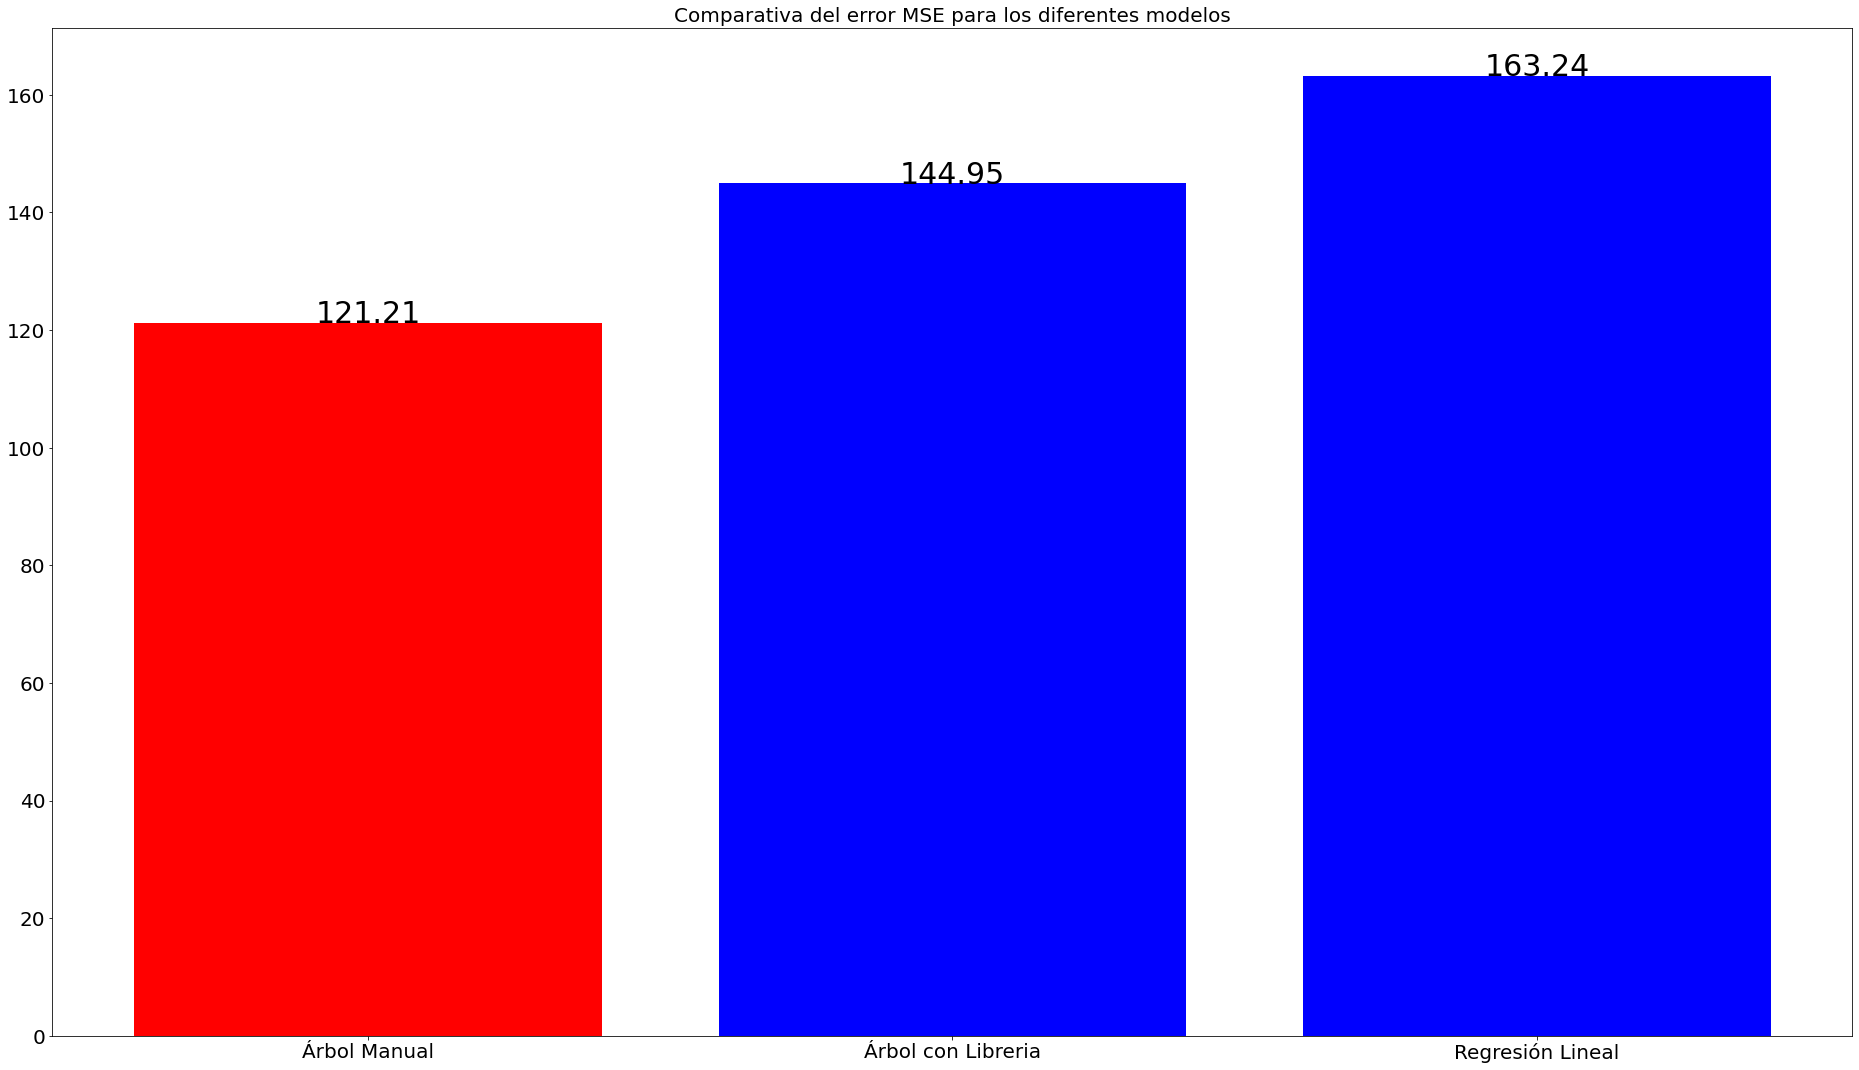

In [58]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparativa del error MSE para los diferentes modelos",fontsize=20)
ejeX = ['Árbol Manual', 'Árbol con Libreria','Regresión Lineal']
ejeY = [float("{0:.2f}".format(rmse_manual)),float("{0:.2f}".format(rmse_libreria)),float("{0:.2f}".format(rmse_regresion))]

ax.bar(ejeX,ejeY,color=['red',"blue","blue"])
def addlabels(x,y,plotP):
    for i in range(len(x)):
        
        plotP.text(i,y[i],y[i],fontsize=30,ha='center')
addlabels(ejeX,ejeY,plt)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [59]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [60]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [61]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

### Árbol de decisión

In [62]:
# Celda 6
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf2 = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf2, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

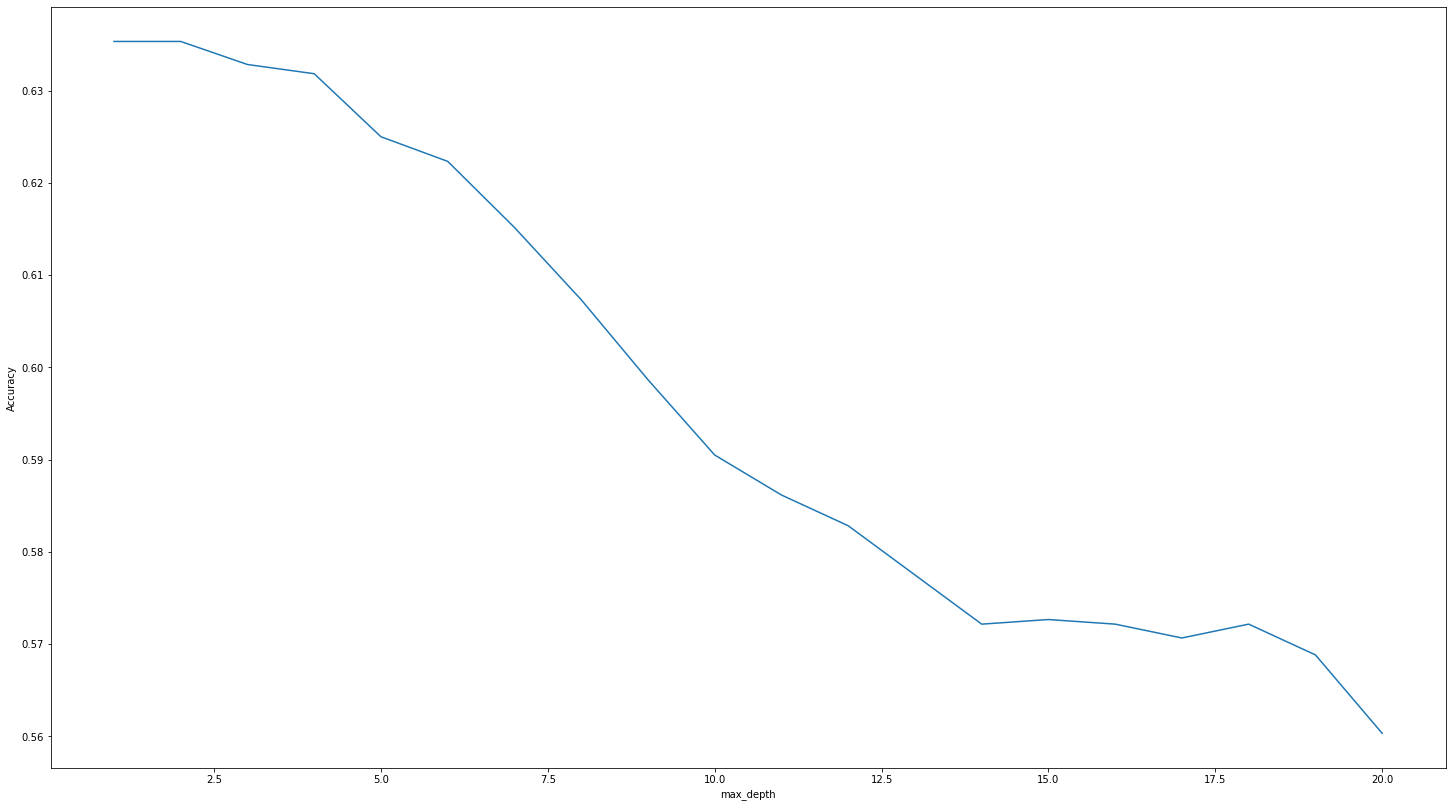

In [63]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [64]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6353333333333333, 2)

In [65]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf2 = DecisionTreeClassifier(max_depth=2, random_state=1)
Tree_ajustado=clf2.fit(X_train, y_train)

In [66]:
# predicciónes 
predTree2 = Tree_ajustado.predict(X_test)

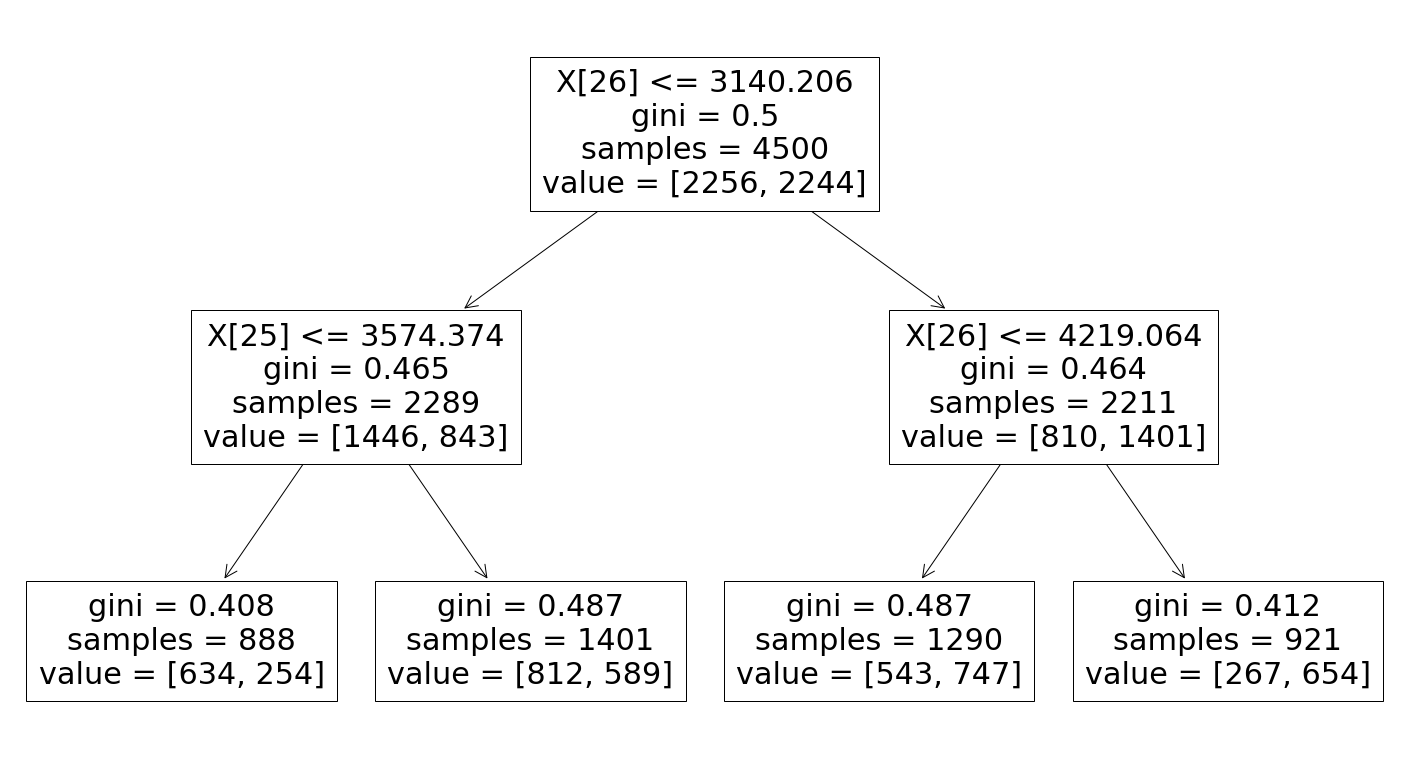

In [67]:
plot_tree(Tree_ajustado,max_depth=2)
plt.show()

In [68]:
# métricas de Accuracy y F1-Score para el Árbol de decisión
print("Accuracy Árbol de decisión:", metrics.accuracy_score(predTree2 , y_test))
print("F1 score Árbol de decisión:", metrics.f1_score(predTree2 , y_test))

Accuracy Árbol de decisión: 0.6453333333333333
F1 score Árbol de decisión: 0.6448598130841121


### Regresión Logística

In [69]:
from sklearn.linear_model import LogisticRegression
clfRegLog= LogisticRegression(random_state=0,max_iter=10000)
clfRegLog.fit(X_train,y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [70]:
# predicciones de regresión Logística
prediccionesRegLog=clfRegLog.predict(X_test)
prediccionesProbRegLog=clfRegLog.predict_proba(X_test)

In [71]:
# métricas de Accuracy y F1-Score para Regresión Logística
print("Accuracy Regresión Logística: ", metrics.accuracy_score(prediccionesRegLog , y_test))
print("F1 score Regresión Logística: ", metrics.f1_score(prediccionesRegLog , y_test))

Accuracy Regresión Logística:  0.622
F1 score Regresión Logística:  0.6092350103376982


El modelo con Árbol de decisión es ligeramente mejor que el de regresion logistica de acuerdo con el Accuracy y el F1 score, sin embargo la predicción en ambos casos no es satisfactoria.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

### 100 árboles de decisión donde max_depth = None

In [72]:
# Celda 7
# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf_arbol_none = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [73]:
# Predicción y desempeño al hacer votación mayoritaria 100 árboles de decisión donde max_depth = None
clf_arbol_none.fit(X_train, y_train)
y_pred_none = clf_arbol_none.predict(X_test)
ac_arbol_none=metrics.accuracy_score(y_pred_none, y_test)
f1_arbol_none=metrics.f1_score(y_pred_none, y_test)
print("Accuracy Árbol maxdepth=None: ",ac_arbol_none)
print("F1 score Árbol maxdepth=None: ", f1_arbol_none)


Accuracy Árbol maxdepth=None:  0.64
F1 score Árbol maxdepth=None:  0.642384105960265


### 100 árboles de decisión donde max_depth = 2

In [74]:
# Definición del modelo BaggingClassifier de la libreria sklearn
from sklearn.ensemble import BaggingClassifier
clf_arbol_2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [75]:
# Predicción y desempeño al hacer votación mayoritaria 100 árboles de decisión donde max_depth = 2
clf_arbol_2.fit(X_train, y_train)
y_pred_2 = clf_arbol_2.predict(X_test)
ac_arbol_2=metrics.accuracy_score(y_pred_2, y_test)
f1_arbol_2=metrics.f1_score(y_pred_2, y_test)
print("Accuracy Árbol maxdepth=2: ", ac_arbol_2)
print("F1 score Árbol maxdepth=2: ", f1_arbol_2)


Accuracy Árbol maxdepth=2:  0.6446666666666667
F1 score Árbol maxdepth=2:  0.6439545758183033


### 100 regresiones logísticas

In [76]:
clf_logistica = BaggingClassifier(base_estimator=LogisticRegression(random_state=0,max_iter=10000), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

In [77]:
# Predicción y desempeño al hacer votación mayoritaria 100 regresiones logisticas
clf_logistica.fit(X_train, y_train)
y_pred_lg = clf_logistica.predict(X_test)
ac_lg=metrics.accuracy_score(y_pred_lg, y_test)
f1_lg=metrics.f1_score(y_pred_lg, y_test)
print("Accuracy Regresión Logística: ", ac_lg)
print("F1 score Regresión Logística: ", f1_lg)

Accuracy Regresión Logística:  0.6253333333333333
F1 score Regresión Logística:  0.6118784530386739


El mejor modelo se da con los 100 árboles de decisión donde max_depth = 2 con los Accuracy y F1 score mas altos

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

### 100 árboles de decisión donde max_depth = None

In [78]:
# Celda 8
clf_arbol_none_vp = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_arbol_none_vp.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=42)

In [79]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf_arbol_none_vp.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_arbol_none_vp.n_estimators))

for i in range(clf_arbol_none_vp.n_estimators):
    oob_sample = ~clf_arbol_none_vp.estimators_samples_[i]
    y_pred_ = clf_arbol_none_vp.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_arbol_none_vp.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_none_vp = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [80]:
# Predicción y desempeño al hacer votación mayoritaria 100 árboles de decisión donde max_depth = None
ac_arbol_nonevp=metrics.accuracy_score(y_pred_none_vp, y_test)
f1_arbol_nonevp=metrics.f1_score(y_pred_none_vp, y_test)
print("Accuracy Árbol maxdepth=None: ", ac_arbol_nonevp)
print("F1 score Árbol maxdepth=None: ", f1_arbol_nonevp)


Accuracy Árbol maxdepth=None:  0.6453333333333333
F1 score Árbol maxdepth=None:  0.6513761467889909


### 100 árboles de decisión donde max_depth = 2

In [81]:
clf_arbol_2vp = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_arbol_2vp.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)

In [82]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf_arbol_2vp.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_arbol_2vp.n_estimators))

for i in range(clf_arbol_2vp.n_estimators):
    oob_sample = ~clf_arbol_2vp.estimators_samples_[i]
    y_pred_ = clf_arbol_2vp.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_arbol_2vp.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_2vp = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [83]:
# Predicción y desempeño al hacer votación mayoritaria 100 árboles de decisión donde max_depth = 2
ac_arbol_2vp=metrics.accuracy_score(y_pred_2vp, y_test)
f1_arbol_2vp=metrics.f1_score(y_pred_2vp, y_test)
print("Accuracy Árbol maxdepth=2: ", ac_arbol_2vp)
print("F1 score Árbol maxdepth=2: ", f1_arbol_2vp)


Accuracy Árbol maxdepth=2:  0.6453333333333333
F1 score Árbol maxdepth=2:  0.6448598130841121


### 100 regresiones logísticas

In [84]:
clf_logistica_vp = BaggingClassifier(base_estimator=LogisticRegression(random_state=0,max_iter=10000), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_logistica_vp.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                    random_state=0),
                  n_estimators=100, n_jobs=-1, oob_score=True, random_state=42)

In [85]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf_logistica_vp.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf_logistica_vp.n_estimators))

for i in range(clf_logistica_vp.n_estimators):
    oob_sample = ~clf_logistica_vp.estimators_samples_[i]
    y_pred_ = clf_logistica_vp.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf_logistica_vp.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred_lgvp = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

In [86]:
# Predicción y desempeño al hacer votación ponderada 100 regresiones logisticas
ac_lg_vp=metrics.accuracy_score(y_pred_lgvp, y_test)
f1_lg_vp=metrics.f1_score(y_pred_lgvp, y_test)
print("Accuracy Regresión Logística: ", ac_lg_vp)
print("F1 score Regresión Logística: ", f1_lg_vp)

Accuracy Regresión Logística:  0.622
F1 score Regresión Logística:  0.6092350103376982


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

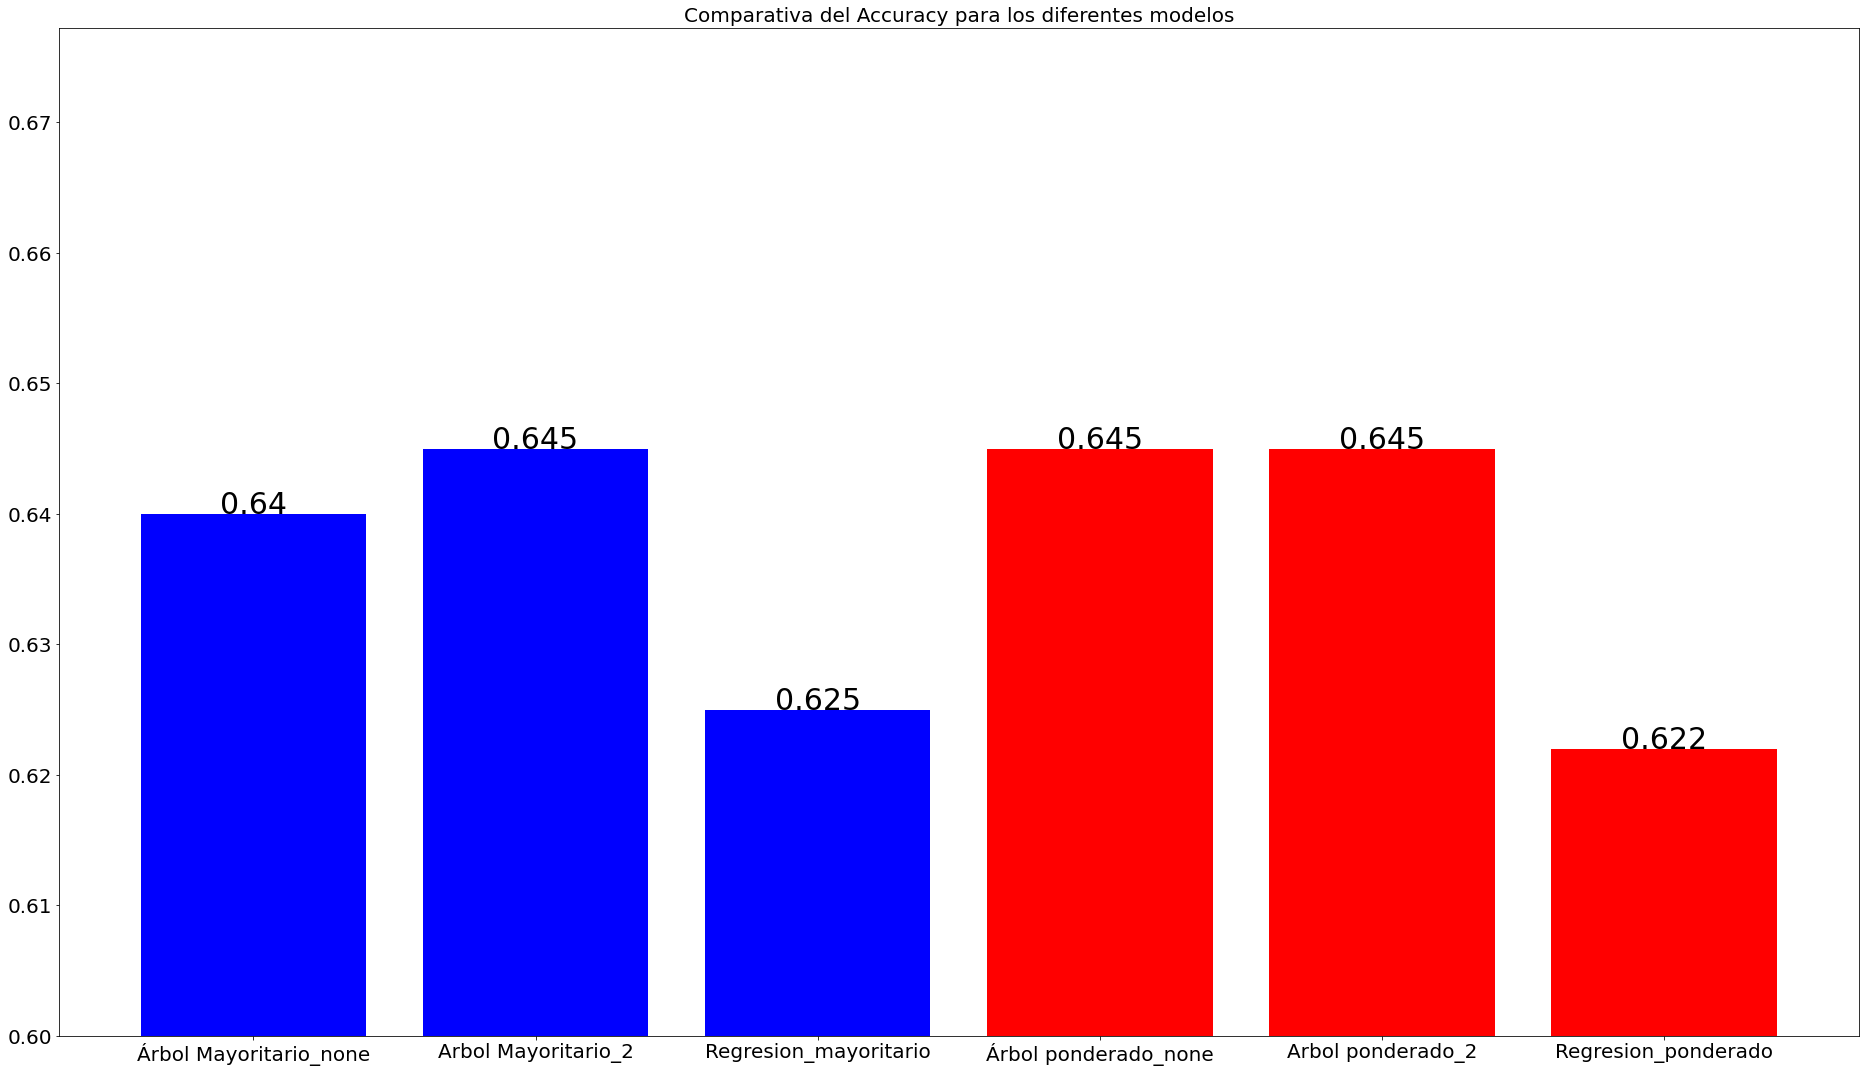

In [87]:
# Celda 9
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparativa del Accuracy para los diferentes modelos",fontsize=20)
ejeX = ['Árbol Mayoritario_none', 'Arbol Mayoritario_2','Regresion_mayoritario','Árbol ponderado_none', 'Arbol ponderado_2','Regresion_ponderado' ]
ejeY = [float("{0:.3f}".format(ac_arbol_none)),float("{0:.3f}".format(ac_arbol_2)),float("{0:.3f}".format(ac_lg)),float("{0:.3f}".format(ac_arbol_nonevp)),float("{0:.3f}".format(ac_arbol_2vp)),float("{0:.3f}".format(ac_lg_vp))]

ax.bar(ejeX,ejeY,color=["blue","blue","blue","red","red","red"])
def addlabels(x,y,plotP):
    for i in range(len(x)):
        
        plotP.text(i,y[i],y[i],fontsize=30,ha='center')
addlabels(ejeX,ejeY,plt)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.6)
plt.show()

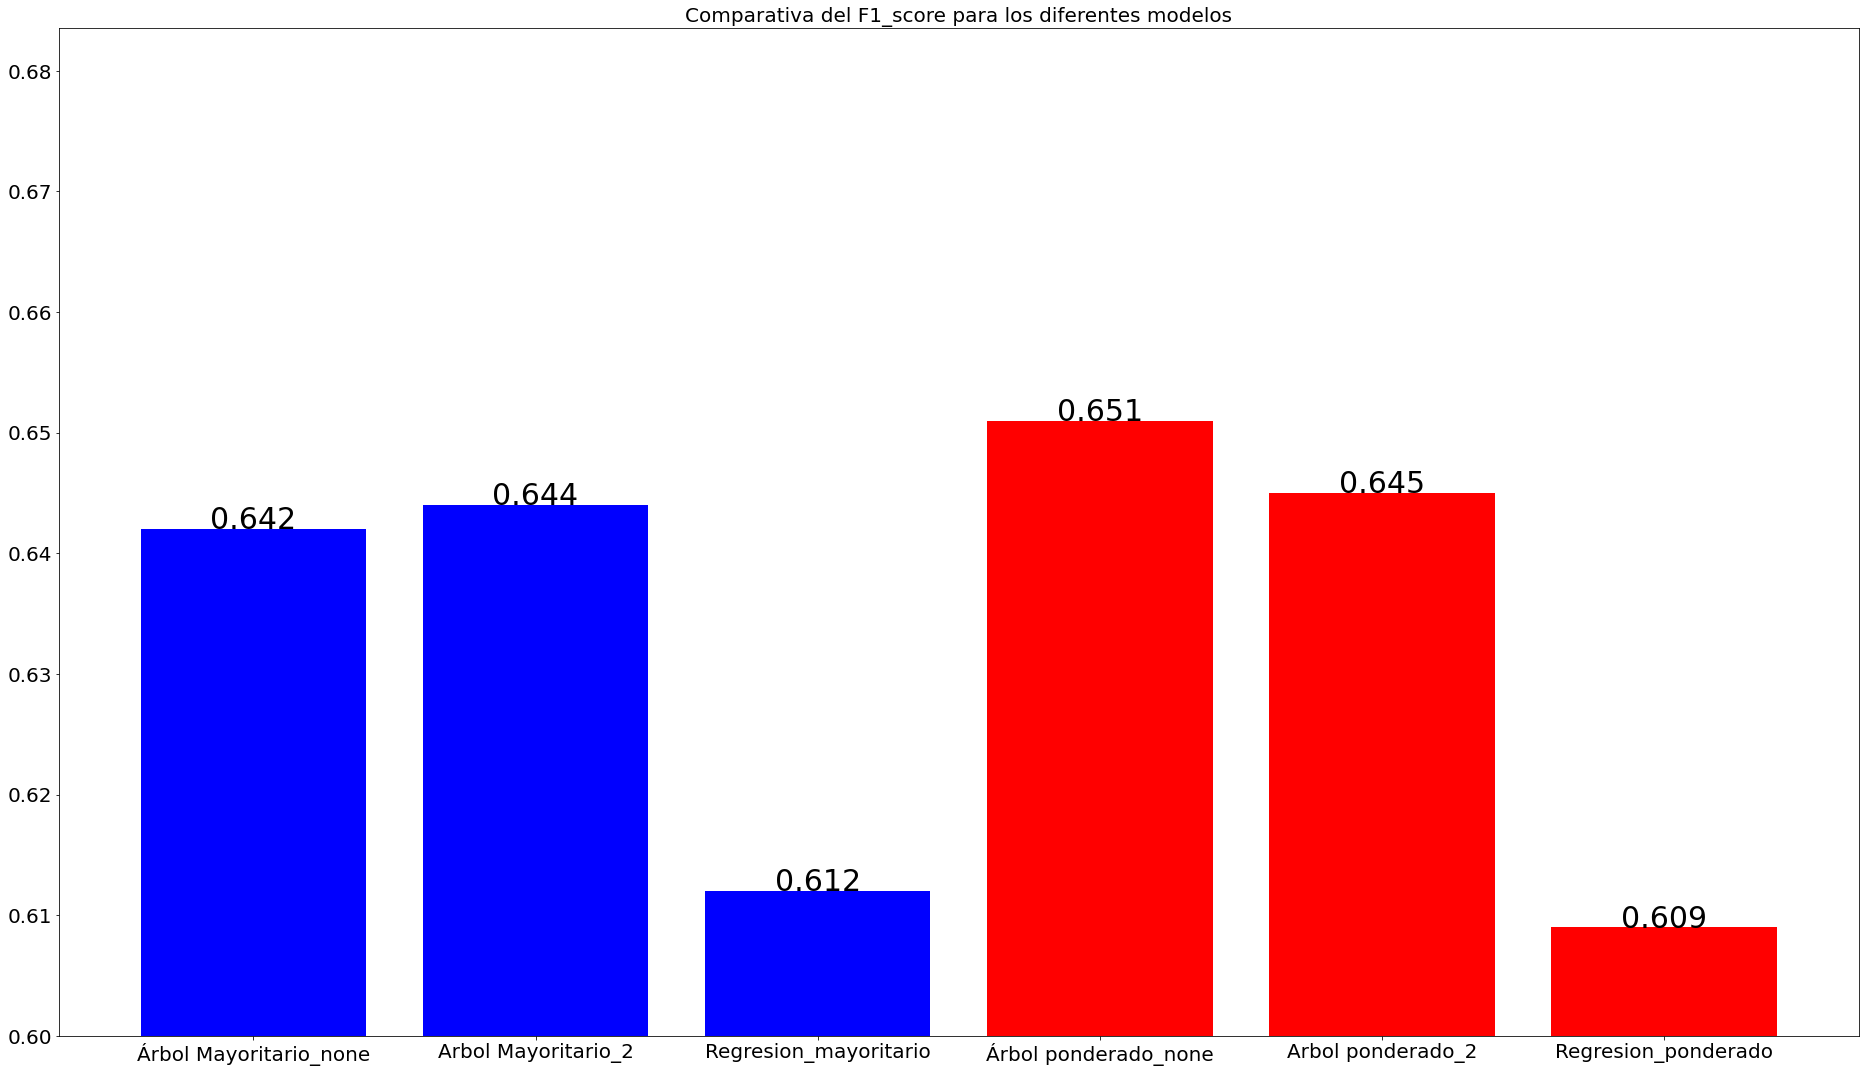

In [88]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparativa del F1_score para los diferentes modelos",fontsize=20)
ejeX = ['Árbol Mayoritario_none', 'Arbol Mayoritario_2','Regresion_mayoritario','Árbol ponderado_none', 'Arbol ponderado_2','Regresion_ponderado' ]
ejeY = [float("{0:.3f}".format(f1_arbol_none)),float("{0:.3f}".format(f1_arbol_2)),float("{0:.3f}".format(f1_lg)),float("{0:.3f}".format(f1_arbol_nonevp)),float("{0:.3f}".format(f1_arbol_2vp)),float("{0:.3f}".format(f1_lg_vp))]

ax.bar(ejeX,ejeY,color=["blue","blue","blue","red","red","red"])
def addlabels(x,y,plotP):
    for i in range(len(x)):
        
        plotP.text(i,y[i],y[i],fontsize=30,ha='center')
addlabels(ejeX,ejeY,plt)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0.6)
plt.show()

Los mejores desempeños se logran con votación ponderada en arboles de decisión y votación mayoritaria en el árbol con max depth=2. Los modelos de regresión logística presentan los valores mas bajos en ambos casos y toman un poco mas de tiempo para ejecutarse, sin embargo, tanto el accuracy como el f1 score son muy cercanos en todos los casos con variaciones máximas cercanas al 4% y no son muy buenos modelos para predecir.
La votación mayoritaria utiliza menos código y en el caso del accuracy para el árbol con max dept=2 tiene los mismos resultados que los arboles ponderados y seria el mejor modelo a elegir. 